In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# path names
root = Path().resolve()
path = root/'dataset'/'Henry_Mpro_pKa'

In [3]:
# the function to read data
def read_data(name):
    table_data = pd.DataFrame({})
    dataset_path = path/name
    for dp in dataset_path.iterdir():
        # structure.pdb does not need to be read here
        if dp.name != 'structure.pdb':
            temp_table = pd.read_table(dp, header=None, names=['#1', '#2'])
            temp_array = (list)(temp_table['#2'])
            table_data[dp.name] = temp_array
            warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    return table_data

In [4]:
S01_table = read_data(name='S01')
S05_table = read_data(name='S05')
p12_table = read_data(name='p12')
p13_table = read_data(name='p13')

S01_index = list(S01_table)
p12_index = list(p12_table)

same_residues = [x for x in S01_index if x in p12_index]

S01_filter = S01_table[same_residues]
S05_filter = S05_table[same_residues]
p12_filter = p12_table[same_residues]
p13_filter = p13_table[same_residues]

In [5]:
def sort_residues(data):
    data_t = data.T
    res_lists = list(data_t.index.values)
    data_t["order"] = None

    for i in range(len(res_lists)):
        tmp_idx = res_lists[i]
        tmp_val = int(tmp_idx[4:])
        data_t.loc[tmp_idx, "order"] = tmp_val

    data_sort = data_t.sort_values(by="order")
    sort_data = data_sort.T
    serial_data = sort_data.drop("order")
    return serial_data


S01_serial = sort_residues(S01_filter)
S05_serial = sort_residues(S05_filter)
p12_serial = sort_residues(p12_filter)
p13_serial = sort_residues(p13_filter)

In [6]:
S01_corr_matrix = S01_serial.corr(method="pearson")
S05_corr_matrix = S05_serial.corr(method="pearson")
p12_corr_matrix = p12_serial.corr(method="pearson")
p13_corr_matrix = p13_serial.corr(method="pearson")

S01_S05_diff = S01_corr_matrix.sub(S05_corr_matrix)
S01_p12_diff = S01_corr_matrix.sub(p12_corr_matrix)
S01_p13_diff = S01_corr_matrix.sub(p13_corr_matrix)

S01_S05_matrix = np.array(S01_S05_diff)
S01_p12_matrix = np.array(S01_p12_diff)
S01_p13_matrix = np.array(S01_p13_diff)

In [70]:
serial_res = list(S01_S05_diff.index.values)


def extract_high_value(matrix, threshold):
    filter_data = pd.DataFrame(columns=["Residue_1", "Residue_2", "Difference"])

    for i in range(len(matrix)-1):
        temp_list = matrix[i][i+1:]
        for j in range(len(temp_list)):
            if abs(temp_list[j]) > threshold:
                res_1 = serial_res[i]
                res_2 = serial_res[i+j+1]
                filter_data.loc[len(filter_data)] = [res_1, res_2, temp_list[j]]

    return filter_data


S01_S05_filter = extract_high_value(S01_S05_matrix, 0.5)
S01_p12_filter = extract_high_value(S01_p12_matrix, 0.5)
S01_p13_filter = extract_high_value(S01_p13_matrix, 0.5)

In [71]:
S01_S05_filter

,Residue_1,Residue_2,Difference
0,ASP_295,ARG_366,0.589254
1,ASP_354,TYR_360,-0.812065
2,TYR_360,ARG_366,0.887981
3,TYR_360,ARG_494,0.644191


In [72]:
def sort_residues_dict(filter_df):
    res_1 = list(filter_df["Residue_1"])
    res_2 = list(filter_df["Residue_2"])
    res_1_2 = res_1 + res_2
    res_idx = list(set(res_1_2))

    init_dict = {}
    for i in range(len(res_idx)):
        init_dict[res_idx[i]] = int(res_idx[i][4:])
    sort_dict = sorted(init_dict.items(), key=lambda kv: (kv[1], kv[0]))
    sort_res = []
    for k, v in sort_dict:
        sort_res.append(k)
    return sort_res


S01_S05_sort_res = sort_residues_dict(S01_S05_filter)
S01_p12_sort_res = sort_residues_dict(S01_p12_filter)
S01_p13_sort_res = sort_residues_dict(S01_p13_filter)

In [73]:
# compute pearson matrix with target residues
def compute_res_matrix(data_table, sort_res):

    corr_df = data_table[sort_res]
    corr_matrix = corr_df.corr(method='pearson')

    return corr_matrix


S01_S05_res_matrix = compute_res_matrix(S01_table, S01_S05_sort_res)
S01_p12_res_matrix = compute_res_matrix(S01_table, S01_p12_sort_res)
S01_p13_res_matrix = compute_res_matrix(S01_table, S01_p13_sort_res)
S05_res_matrix = compute_res_matrix(S05_table, S01_S05_sort_res)
p12_res_matrix = compute_res_matrix(p12_table, S01_p12_sort_res)
p13_res_matrix = compute_res_matrix(p13_table, S01_p13_sort_res)

S01_S05_res_diff = S01_S05_res_matrix.sub(S05_res_matrix)
S01_p12_res_diff = S01_p12_res_matrix.sub(p12_res_matrix)
S01_p13_res_diff = S01_p13_res_matrix.sub(p13_res_matrix)

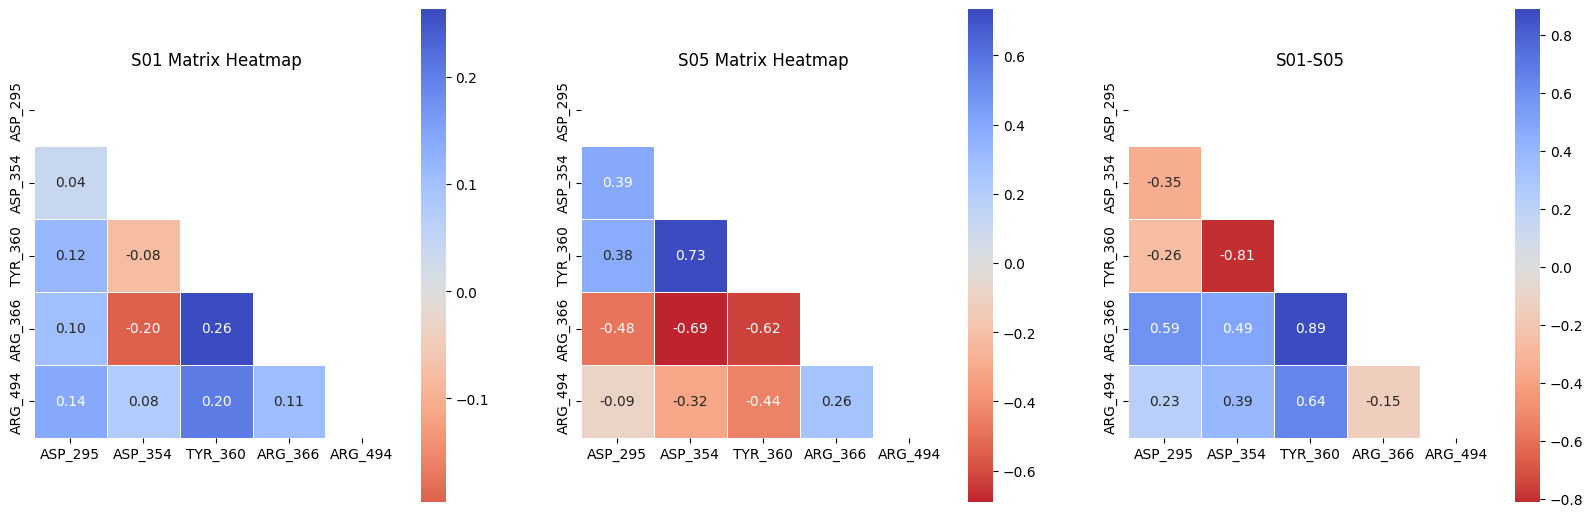

In [74]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
S01_S05_mask = np.triu(np.ones_like(S01_S05_res_matrix, dtype=bool))
S01_S05_labels = S01_S05_res_matrix.map(lambda v: v if v else '')
plot = sns.heatmap(S01_S05_res_matrix, mask=S01_S05_mask, annot=S01_S05_labels,
                   fmt='.2f', cmap='coolwarm_r', center=0, square=True,
                   linewidths=.5, cbar_kws={"shrink": .8})
plt.title("S01 Matrix Heatmap")

plt.subplot(1, 3, 2)
S05_mask = np.triu(np.ones_like(S05_res_matrix, dtype=bool))
S05_labels = S05_res_matrix.map(lambda v: v if v else '')
plot = sns.heatmap(S05_res_matrix, mask=S05_mask, annot=S05_labels,
                   fmt='.2f', cmap='coolwarm_r', center=0, square=True,
                   linewidths=.5, cbar_kws={"shrink": .8})
plt.title("S05 Matrix Heatmap")

plt.subplot(1, 3, 3)
S01_S05_diff_mask = np.triu(np.ones_like(S01_S05_res_diff, dtype=bool))
S01_S05_diff_labels = S01_S05_res_diff.map(lambda v: v if v else '')
plot = sns.heatmap(S01_S05_res_diff, mask=S01_S05_diff_mask,
                   annot=S01_S05_diff_labels, fmt='.2f', cmap='coolwarm_r',
                   center=0, square=True, linewidths=.5,
                   cbar_kws={"shrink": .8})
plt.title("S01-S05")

plt.savefig('./figure/diff_matrix/S01_S05_matrix.png')
plt.show()

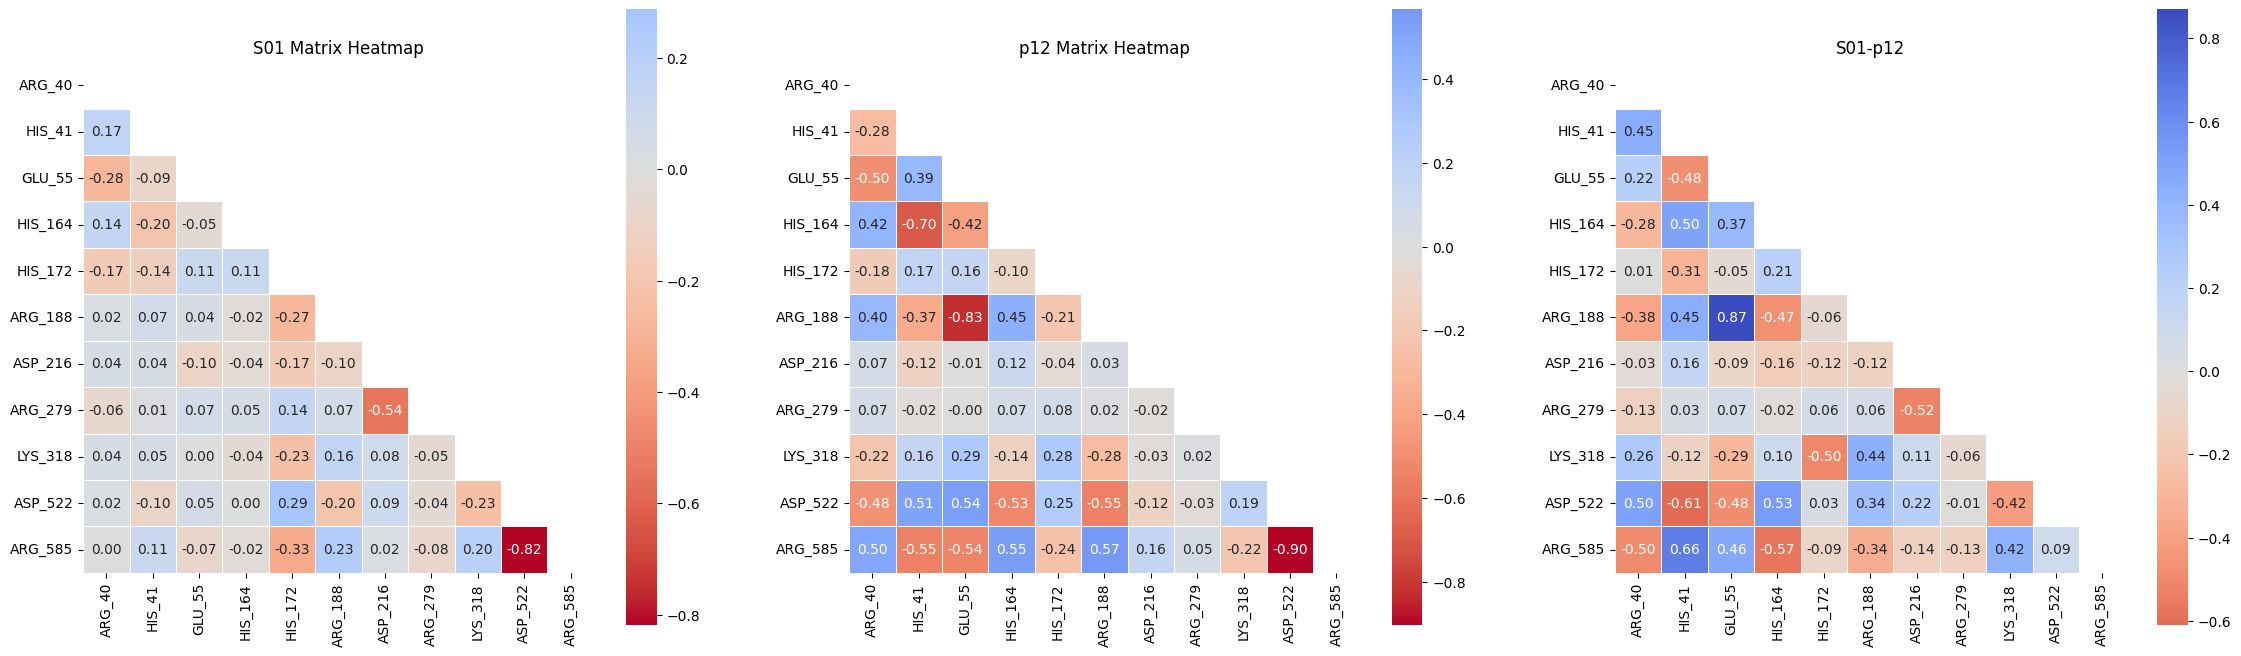

In [75]:
plt.figure(figsize=(28, 10))

plt.subplot(1, 3, 1)
S01_p12_mask = np.triu(np.ones_like(S01_p12_res_matrix, dtype=bool))
S01_p12_labels = S01_p12_res_matrix.map(lambda v: v if v else '')
plot = sns.heatmap(S01_p12_res_matrix, mask=S01_p12_mask, annot=S01_p12_labels,
                   fmt='.2f', cmap='coolwarm_r', center=0, square=True,
                   linewidths=.5, cbar_kws={"shrink": .8})
plt.title("S01 Matrix Heatmap")

plt.subplot(1, 3, 2)
p12_mask = np.triu(np.ones_like(p12_res_matrix, dtype=bool))
p12_labels = p12_res_matrix.map(lambda v: v if v else '')
plot = sns.heatmap(p12_res_matrix, mask=p12_mask, annot=p12_labels,
                   fmt='.2f', cmap='coolwarm_r', center=0, square=True,
                   linewidths=.5, cbar_kws={"shrink": .8})
plt.title("p12 Matrix Heatmap")

plt.subplot(1, 3, 3)
S01_p12_diff_mask = np.triu(np.ones_like(S01_p12_res_diff, dtype=bool))
S01_p12_diff_labels = S01_p12_res_diff.map(lambda v: v if v else '')
plot = sns.heatmap(S01_p12_res_diff, mask=S01_p12_diff_mask,
                   annot=S01_p12_diff_labels, fmt='.2f', cmap='coolwarm_r',
                   center=0, square=True, linewidths=.5,
                   cbar_kws={"shrink": .8})
plt.title("S01-p12")

plt.savefig('./figure/diff_matrix/S01_p12_matrix.png')
plt.show()

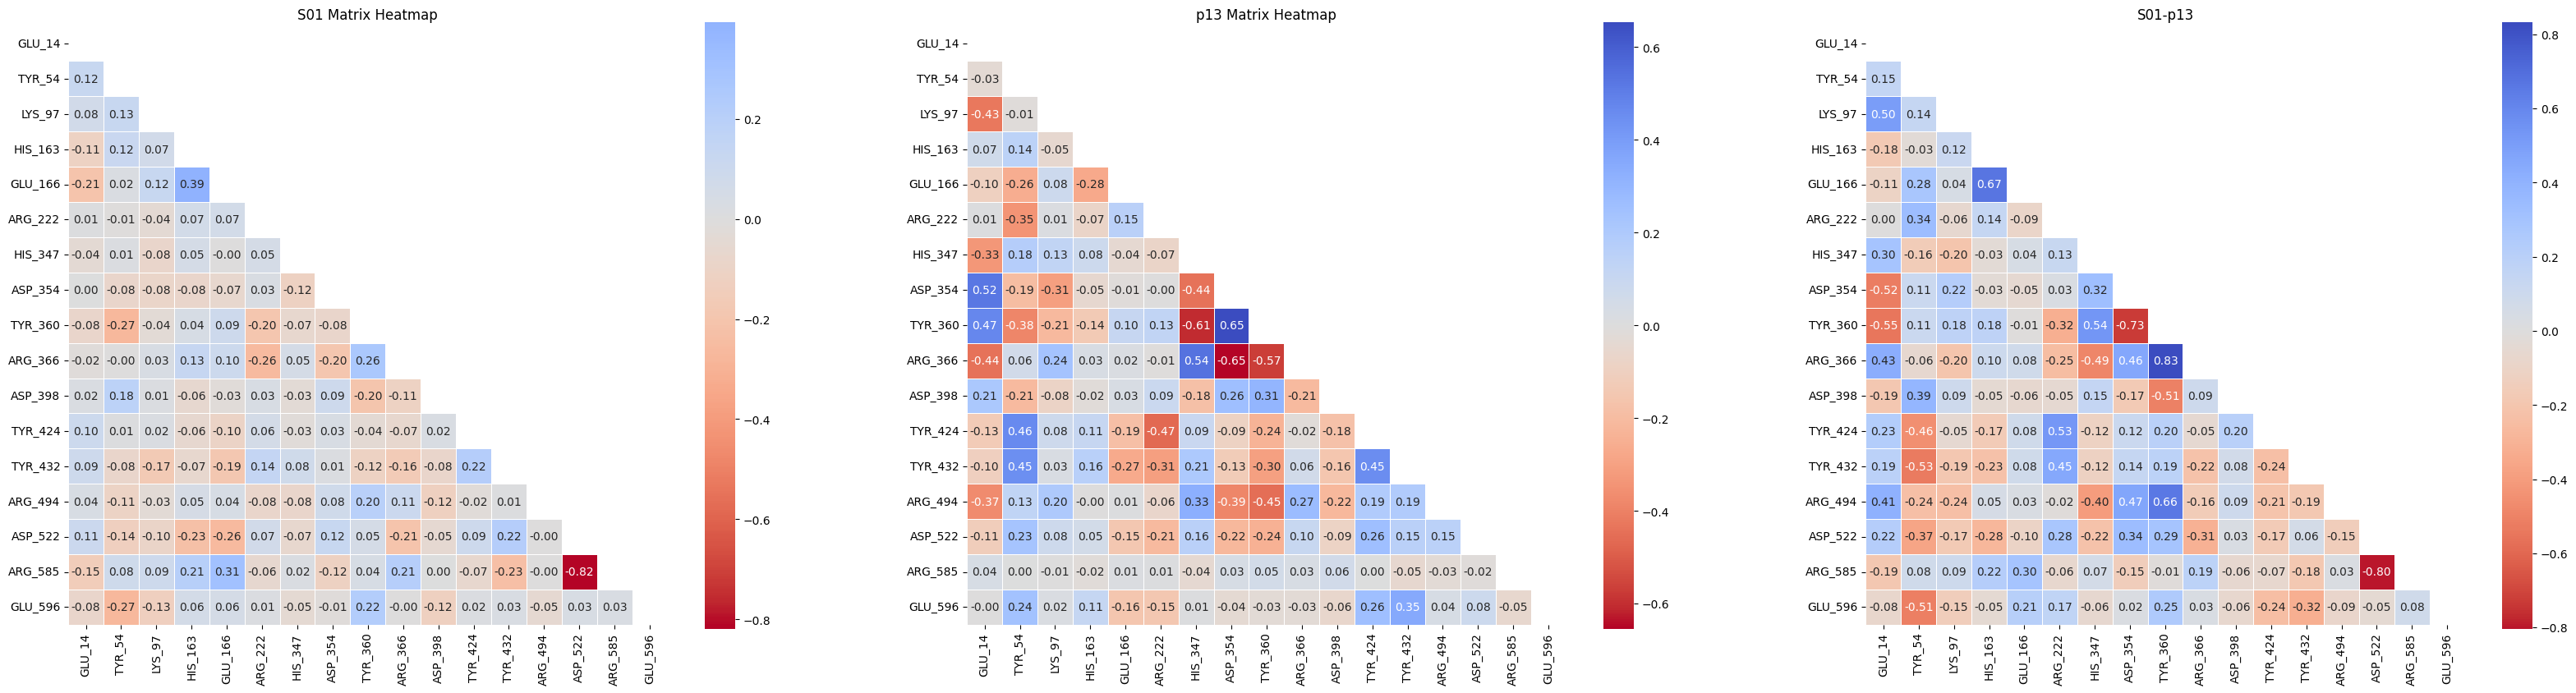

In [76]:
plt.figure(figsize=(40, 12))

plt.subplot(1, 3, 1)
S01_p13_mask = np.triu(np.ones_like(S01_p13_res_matrix, dtype=bool))
S01_p13_labels = S01_p13_res_matrix.map(lambda v: v if v else '')
plot = sns.heatmap(S01_p13_res_matrix, mask=S01_p13_mask, annot=S01_p13_labels,
                   fmt='.2f', cmap='coolwarm_r', center=0, square=True,
                   linewidths=.5, cbar_kws={"shrink": .8})
plt.title("S01 Matrix Heatmap")

plt.subplot(1, 3, 2)
p13_mask = np.triu(np.ones_like(p13_res_matrix, dtype=bool))
p13_labels = p13_res_matrix.map(lambda v: v if v else '')
plot = sns.heatmap(p13_res_matrix, mask=p13_mask, annot=p13_labels,
                   fmt='.2f', cmap='coolwarm_r', center=0, square=True,
                   linewidths=.5, cbar_kws={"shrink": .8})
plt.title("p13 Matrix Heatmap")

plt.subplot(1, 3, 3)
S01_p13_diff_mask = np.triu(np.ones_like(S01_p13_res_diff, dtype=bool))
S01_p13_diff_labels = S01_p13_res_diff.map(lambda v: v if v else '')
plot = sns.heatmap(S01_p13_res_diff, mask=S01_p13_diff_mask,
                   annot=S01_p13_diff_labels, fmt='.2f', cmap='coolwarm_r',
                   center=0, square=True, linewidths=.5,
                   cbar_kws={"shrink": .8})
plt.title("S01-p13")

plt.savefig('./figure/diff_matrix/S01_p13_matrix.png')
plt.show()

In [114]:
S01_S05_columns = ['Residue_1', 'Residue_2', 'S01_Correlation',
                   'S05_Correlation', 'Difference']
S01_p12_columns = ['Residue_1', 'Residue_2', 'S01_Correlation',
                   'p12_Correlation', 'Difference']
S01_p13_columns = ['Residue_1', 'Residue_2', 'S01_Correlation',
                   'p13_Correlation', 'Difference']

S01_S05_compare = S01_S05_filter.reindex(columns=S01_S05_columns, fill_value=0.0)
S01_p12_compare = S01_p12_filter.reindex(columns=S01_p12_columns, fill_value=0.0)
S01_p13_compare = S01_p13_filter.reindex(columns=S01_p13_columns, fill_value=0.0)

In [117]:
S01_S05_res1_list = list(S01_S05_compare["Residue_1"])
S01_S05_res2_list = list(S01_S05_compare["Residue_2"])
for i in range(len(S01_S05_res1_list)):
    S01_S05_compare.loc[i, 'S01_Correlation'] = S01_corr_matrix.at[S01_S05_res1_list[i], S01_S05_res2_list[i]]
    S01_S05_compare.loc[i, 'S05_Correlation'] = S05_corr_matrix.at[S01_S05_res1_list[i], S01_S05_res2_list[i]]

S01_p12_res1_list = list(S01_p12_compare["Residue_1"])
S01_p12_res2_list = list(S01_p12_compare["Residue_2"])
for i in range(len(S01_p12_res1_list)):
    S01_p12_compare.loc[i, 'S01_Correlation'] = S01_corr_matrix.at[S01_p12_res1_list[i], S01_p12_res2_list[i]]
    S01_p12_compare.loc[i, 'p12_Correlation'] = p12_corr_matrix.at[S01_p12_res1_list[i], S01_p12_res2_list[i]]

S01_p13_res1_list = list(S01_p13_compare["Residue_1"])
S01_p13_res2_list = list(S01_p13_compare["Residue_2"])
for i in range(len(S01_p13_res1_list)):
    S01_p13_compare.loc[i, 'S01_Correlation'] = S01_corr_matrix.at[S01_p13_res1_list[i], S01_p13_res2_list[i]]
    S01_p13_compare.loc[i, 'p13_Correlation'] = p13_corr_matrix.at[S01_p13_res1_list[i], S01_p13_res2_list[i]]

In [118]:
S01_S05_compare

,Residue_1,Residue_2,S01_Correlation,S05_Correlation,Difference
0,ASP_295,ARG_366,0.104437,-0.484818,0.589254
1,ASP_354,TYR_360,-0.078883,0.733182,-0.812065
2,TYR_360,ARG_366,0.263119,-0.624862,0.887981
3,TYR_360,ARG_494,0.202604,-0.441586,0.644191


In [119]:
S01_p12_compare

,Residue_1,Residue_2,S01_Correlation,p12_Correlation,Difference
0,ARG_40,ASP_522,0.022535,-0.479909,0.502443
1,HIS_41,ASP_522,-0.096730,0.514682,-0.611412
2,HIS_41,ARG_585,0.108224,-0.552878,0.661102
3,GLU_55,ARG_188,0.042671,-0.826638,0.869309
4,HIS_164,ASP_522,0.004112,-0.526283,0.530396
5,HIS_164,ARG_585,-0.020853,0.545394,-0.566247
6,HIS_172,LYS_318,-0.225755,0.278029,-0.503783
7,ASP_216,ARG_279,-0.538997,-0.018773,-0.520224


In [120]:
S01_p13_compare

,Residue_1,Residue_2,S01_Correlation,p13_Correlation,Difference
0,GLU_14,LYS_97,0.075566,-0.426418,0.501984
1,GLU_14,ASP_354,0.003488,0.523850,-0.520362
2,GLU_14,TYR_360,-0.076569,0.474128,-0.550698
3,TYR_54,TYR_432,-0.083789,0.446681,-0.530470
4,TYR_54,GLU_596,-0.272519,0.241020,-0.513540
5,HIS_163,GLU_166,0.394176,-0.275289,0.669465
6,ARG_222,TYR_424,0.062171,-0.466350,0.528520
7,HIS_347,TYR_360,-0.070125,-0.607861,0.537736
8,ASP_354,TYR_360,-0.078883,0.654308,-0.733191
9,TYR_360,ARG_366,0.263119,-0.570665,0.833784


In [121]:
S01_S05_compare.to_csv('./processed/high_diff/S01_S05_diff.csv', index=False)
S01_p12_compare.to_csv('./processed/high_diff/S01_p12_diff.csv', index=False)
S01_p13_compare.to_csv('./processed/high_diff/S01_p13_diff.csv', index=False)